# Prototype Version 2
This code will read data from an tsv file, this file contains associations of tandem spectra and their corresponding amino acids sequence. I will find the corresponding spectra in an mzML file. This code will then <b>visualize</b> spectra, <b>identify</b> the peaks and based on the distances between the peaks (which are assumed to be y-ions) <b>recognize</b> the amino acid sequence of the original peptide <br>
this will be done using the <b>DeNovo </b> approach presented by Nick Webb (https://www.weddslist.com/ms/tandem.html)

I will investigate how well my programs predict the amino acid sequence by comparing the actual vs predicted sequence.

At the end, in order to check my results, I will use the pyteomics.pylab_aux module to test my annotations and visualize the annotated spectrum.

In [1]:
# basic dependencies and useful math/organization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to read mzML files
from pyteomics import mzml

# to visualize mzML
from pyteomics import pylab_aux as pa, usi

# to find peaks
from scipy.signal import find_peaks
from peakutils import indexes

## reading the files

In [6]:
# file that contains the associations between tandem spectra name and amino acids sequence
df = pd.read_csv("../data/psm_a.tsv", sep="\t")

In [7]:
df.head()

,Spectrum,Spectrum File,Peptide,Modified Peptide,Extended Peptide,Prev AA,Next AA,Peptide Length,Charge,Retention,...,Protein Description,Mapped Genes,Mapped Proteins,Parent Scan Number,Apex Retention Time,Apex Scan Number,Retention Time Start,Retention Time End,Retention Time FWHM,Traced Scans
0,2015-05-19_MRC5_a.05045.05045.4,interact.pep.xml,VHGPGIQSGTTNKPNK,NaN,GCDPSRVR.VHGPGIQSGTTNKPNK.FTVETRGA,R,F,16,4,833.6553,...,Filamin-A,NaN,NaN,5044,837.50806,5075,820.00700,860.02106,14.907001,66
1,2015-05-19_MRC5_a.05137.05137.3,interact.pep.xml,YHTVNGHNCEVR,YHTVNGHNCEVR,VDKIVIQK.YHTVNGHNCEVR.KALSKQEM,K,K,12,3,848.0802,...,Heterogeneous nuclear ribonucleoprotein A1,HNRNPA1L3,sp|A0A2R8Y4L2|RA1L3_HUMAN,5134,0.00000,0,0.00000,0.00000,0.000000,0
2,2015-05-19_MRC5_a.05268.05268.3,interact.pep.xml,NQTAEKEEFEHQQK,NaN,EIINWLDK.NQTAEKEEFEHQQK.ELEKVCNP,K,E,14,3,867.4215,...,Heat shock cognate 71 kDa protein,NaN,NaN,5267,855.37700,5188,834.13904,922.82404,20.950000,133
3,2015-05-19_MRC5_a.05273.05273.3,interact.pep.xml,RDHALLEEQSK,NaN,KVQQLVPK.RDHALLEEQSK.QQSNEHLR,K,Q,11,3,868.4587,...,Alpha-actinin-4,NaN,NaN,5272,873.95000,5310,860.02106,902.49304,17.305000,63
4,2015-05-19_MRC5_a.05307.05307.3,interact.pep.xml,IECDDKGDGSCDVR,IECDDKGDGSCDVR,VEGPSQAK.IECDDKGDGSCDVR.YWPQEAGE,K,Y,14,3,873.5540,...,Filamin-A,FLNC,sp|Q14315|FLNC_HUMAN,5306,860.02106,5221,830.17100,912.24900,16.953001,118


In [9]:
# file that contains the amino acids and their weights
# TODO for now there is a distinction between "I" and "L" which are indistinguishable by weight so I cant really know which one it is
aa = pd.read_csv("../data/single_double_amino_acids.csv")

In [10]:
first_spectra = df[df["Spectrum"] == "2015-05-19_MRC5_a.12623.12623.3"]

In [11]:
mz_path = '../data/2015-05-19_MRC5_a.mzML'

In [12]:
i = 0
with mzml.MzML(mz_path) as reader:
    for spectrum in reader:
        # looking for the first match between the 2 files
        # if spectrum.get('ms level') == 2:
        #     i += 1
        if "2015-05-19_MRC5_a.12623.12623.3" in spectrum.get('spectrum title'):
            print(spectrum["index"])
            # Extract relevant information
            mz_array = spectrum['m/z array']
            intensity_array = spectrum['intensity array']
            precursor_mz = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z']

            plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}
            break

12622


In [13]:
spectrum.get("spectrum title")

'2015-05-19_MRC5_a.12623.12623.3 File:"2015-05-19_MRC5_a.raw", NativeID:"controllerType=0 controllerNumber=1 scan=12623"'

In [14]:
first_spectra["Peptide"][3288]

'FKIPGSPPESMGR'

## Finding Peaks

<Axes: xlabel='m/z', ylabel='intensity'>

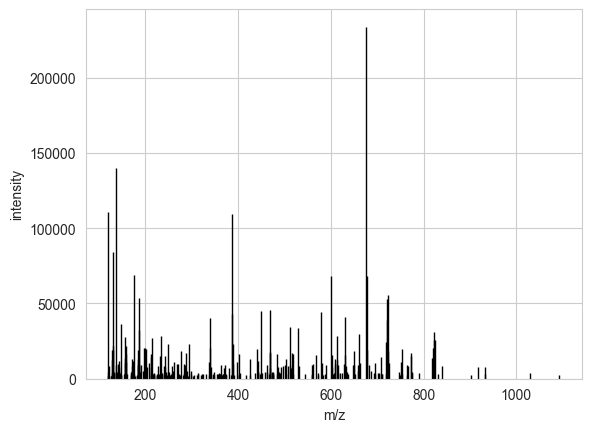

In [15]:
s1 = pd.DataFrame(plotting_dict)
pa.plot_spectrum(s1)

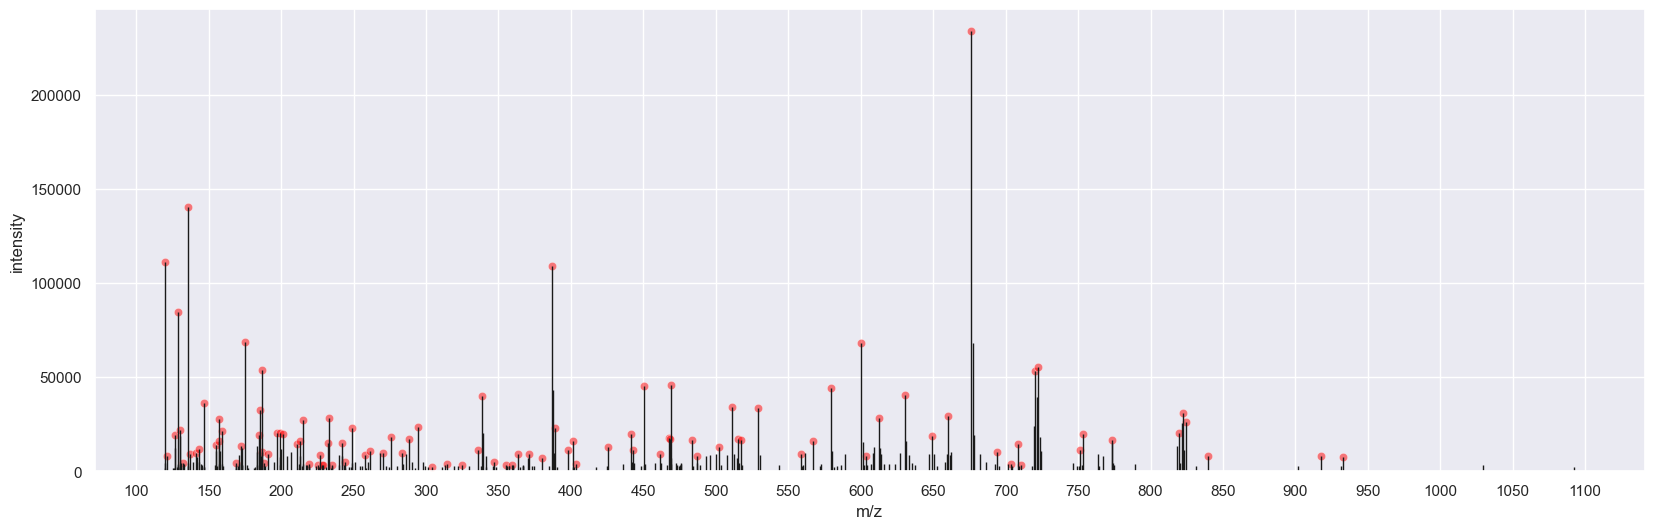

<Figure size 1200x600 with 0 Axes>

In [16]:
sp_height = None
sp_dist = None
sp_prom = None
#TODO find ways to optimize for these parameters, possible based on characteristics of each spectrum
# i.e.: based on how long we expect the amino acid sequence to be
# what determines wheter a peak is useful, is there someway we can find out?
#

sci_peak, _ = find_peaks(s1["intensity array"],
                      height=sp_height,
                      distance=sp_dist,
                      prominence=sp_prom
                      )
sns.set_theme(rc={'figure.figsize':(20,6)})
sns.scatterplot(data = s1.iloc[sci_peak].reset_index(),
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5).set_xticks(np.arange(0,1200,50))
pa.plot_spectrum(plotting_dict)
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.figure(figsize=(12,6))
plt.show()

<Axes: xlabel='m/z', ylabel='intensity'>

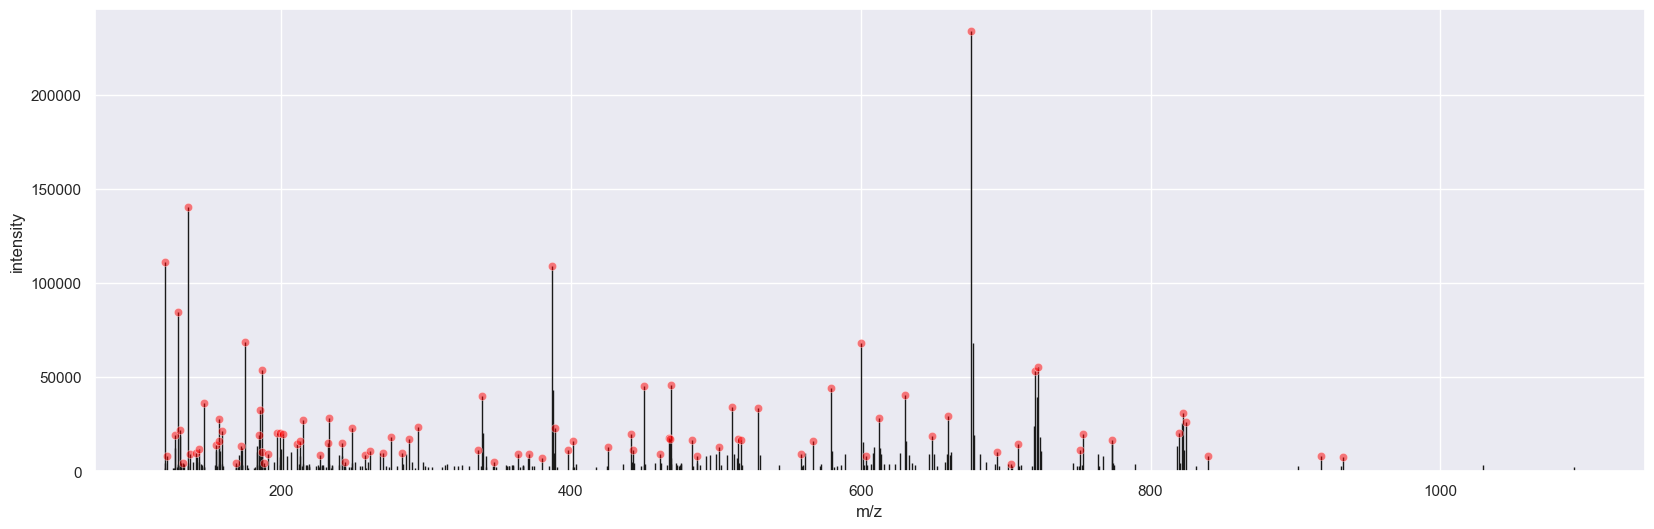

In [17]:
pu_mdist = 1
pu_thres_ = 0.01
util_peak = indexes(s1["intensity array"],
             min_dist=pu_mdist,
             thres=pu_thres_
             )
pa.plot_spectrum(plotting_dict)
sns.scatterplot(data = s1.iloc[util_peak],
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5)

## annotating the spectra with pyteomics

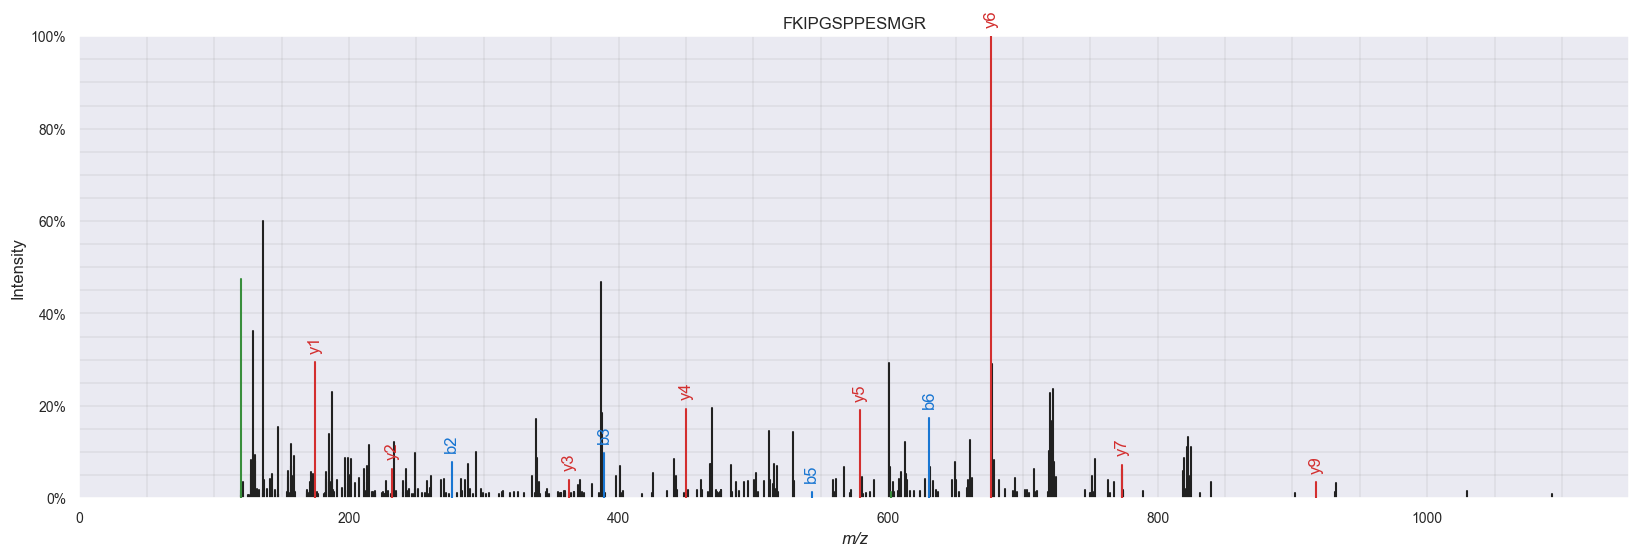

In [18]:
peptide = first_spectra["Peptide"][3288]

pa.annotate_spectrum(plotting_dict, peptide, precursor_charge=2, backend='spectrum_utils',
    ion_types='aby', title=peptide)
plt.show()

## Finding the sequence

In [19]:
# import importlib
# import other_files.my_funcs as mine
# importlib.reload(mine)
# from other_files.my_funcs import find_aa_seq

In [20]:
def find_closest_aa(combo_df, value,thres = 5):
    """ Find the closest amino acid to a given mass.
    this code takes a dataframe with single amino acids and combinations of amino acids in this format

        full    letter  short   comp    mono    mass    G           A           S           P   V etc.
    0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
    1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
    etc.

    using this dataframe and a given mass, it will find the closest amino acid
     or combination of 2 amino acids to the given mass.
    It will only return amino acids that are within the threshold.
    It returns a list of lists, where each list contains the letter of the amino acid, its mass and the error.
    """
    single_df = combo_df.iloc[:,:-22]
    double_df = combo_df.set_index(["letter"]).iloc[
                :,[i for i in range(-22, -0)]]
    closeness_list = []
    # find the closest single amino acids
    loop_for_single = True
    while loop_for_single:
        aam_array = np.asarray(single_df["mono mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        if error > thres:
            loop_for_single = False
        else:
            name_idx = single_df["letter"].iloc[idx]
            closeness_list.append([name_idx, aam_array[idx], error])
            single_df = single_df.drop(single_df.index[idx])
    # find closest combination of amino acids
    loop_for_combo = True
    while loop_for_combo:
        error = (np.abs(double_df - value)).min().min()
        r, c = np.where(double_df == error + value)
        # if error wouldve been negative np.where will not find r, c
        # and pass empty arrays creating error
        if r.size == 0 :
            # print("boink")
            r, c = np.where(double_df == value - error)
        if error > thres:
            loop_for_combo = False
        else:
            name_idx = double_df.index[r[0]]+ "+" + double_df.columns[c[0]]
            closeness_list.append([name_idx, double_df.iloc[r[0],c[0]], error])
            double_df.iloc[r[0],c[0]] = None
    # print("closest aa is: ", name_idx, " ,with mass: ",
    # aam_array[idx], "Da. With an error of: ", error, "Da.")
    closeness_list.sort(key=lambda x: x[2])
    return closeness_list

'''
I would love to decided a closeness factor by iterating over the weights
and seeing how close they are to each other on average. Does this make sense?
'''

'\nI would love to decided a closeness factor by iterating over the weights\nand seeing how close they are to each other on average. Does this make sense?\n'

In [21]:
# def find_aa_seq(data_df,amino_acid_df,precursor_mz=None,
#                 thres = 1):
#     """ This function will find the amino acid sequence of a peptide based on the distance between the peaks.
#
#     :param data_df: receives a dataframe with m/z and intensity values of the peaks that have been previously identified.
#     :param amino_acid_df: receives a dataframe with amino acids and their weights. In the following format:
#
#           full    letter  short   comp    mono    mass    G           A           S           P   V etc.
#     0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
#     1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
#     etc.
#
#     :param precursor_mz: can receive a precursor m/z value, if not given it will use the max value in the dataframe.
#      precursor m/z is used as a max peak to ignore any peaks above whats possible for the peptide.
#     :param aa_found_thres: Difference between peak distance and amino acid weight when a hit is counted as a hit. Will only accept amino acids that fall within that threshold
#
#     :return: list of amino acid letters.
#     """
#     if precursor_mz is not None:
#         data_df.drop(data_df[data_df["m/z array"] == precursor_mz].index, inplace=True)
#     prev_peak = data_df["m/z array"].max()
#     aa_sequence = []
#     for i in range(1,len(data_df["m/z array"])):
#         # choose peak we want to assess distance to
#         peak = data_df["m/z array"].iloc[-i]
#         dist = prev_peak - peak
#         possible_aa = find_closest_aa(amino_acid_df, dist, thres)
#         # if possible amino acids below the threshold have been found
#         if len(possible_aa) > 0:
#             # print("possible amino acids: ", possible_aa)
#             aa_sequence.append(possible_aa[0][0])
#             # print("distance between: ", prev_peak, " and: ",
#             # peak, " is: ", dist)
#             prev_peak = peak
#     return aa_sequence

In [32]:
# TODO find a good confidence score metric by some kind of formula
# TODO maybe write a new function that works more puzzle-like?
# something that can identify all possible relations between the peaks selected
# TODO finding the initial point from which to start regressing over the spectrum is complicated
# maybe the puzzle method is helpful here
# TODO turn peaks into percentages by dividing by the max peak
# should turn confidence scores into a more readable metric

def find_aa_seq_info(data_df,amino_acid_df,info,precursor_mz=None,
                thres = 1):
    """ This function will find the amino acid sequence of a peptide based on the distance between the peaks.

    :param data_df: receives a dataframe with m/z and intensity values of the peaks that have been previously identified.
    :param amino_acid_df: receives a dataframe with amino acids and their weights. In the following format:

          full    letter  short   comp    mono    mass    G           A           S           P   V etc.
    0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
    1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
    etc.

    :param info: list of amino acids that are already certain to be present in the peptide. This list should move end to beginning, i.e.: ["S","M","G","R"] where the peptide is XXXXXSMGR
    :param precursor_mz: can receive a precursor m/z value, if not given it will use the max value in the dataframe.
     precursor m/z is used as a max peak to ignore any peaks above whats possible for the peptide.
    :param aa_found_thres: Difference between peak distance and amino acid weight when a hit is counted as a hit. Will only accept amino acids that fall within that threshold

    :return: list of amino acid letters.
    """

    # # removing the precursor
    # if precursor_mz is not None:
    #     data_df = data_df.drop(data_df[np.around(data_df["m/z array"],0) == np.around(precursor_mz,0)].index)

    #prev_peak = data_df["m/z array"].max()
    prev_peak = precursor_mz*2
    aa_sequence = []
    c_score = 0
    for i in range(1,len(data_df["m/z array"])):
        # choose peak we want to assess distance to
        peak = data_df["m/z array"].iloc[-i]
        dist = prev_peak - peak
        possible_aa = find_closest_aa(amino_acid_df, dist, thres)
        # if possible amino acids below the threshold have been found
        if len(possible_aa) > 0:
            # print(possible_aa[0][0], possible_aa[0][2])
            # confidence score function: intensity
            c_score += data_df["intensity array"].iloc[-i]
            mz = 0
            aa_sequence.append([possible_aa[0][0]])
            # print("distance between: ", prev_peak, " and: ",
            # peak, " is: ", dist)
            prev_peak = peak
        c_score = c_score / np.sum(data_df["intensity array"])
    return aa_sequence

In [33]:
s1.iloc[sci_peak].reset_index()

,index,m/z array,intensity array
0,1,120.081062,111044.421875
1,3,121.084648,8364.300781
2,7,127.086716,19389.990234
3,10,129.102448,84495.460938
4,14,130.086548,21894.462891
...,...,...,...
99,327,822.449036,31098.123047
100,329,824.398499,26049.781250
101,331,839.459839,8250.591797
102,333,917.413147,8086.908691


In [34]:
finding_df = s1.iloc[sci_peak].reset_index()
info = ["S","M","G","R"]

In [35]:
len(finding_df)

104

In [36]:
find_thres = 2
peak_thres = 0.001

find_aa_seq_info(finding_df,aa,info, precursor_mz=precursor_mz, thres=find_thres)

[['P'], ['S'], ['G'], ['D'], ['P'], ['G'], ['A'], ['A'], ['G'], ['G']]

In [27]:
first_spectra["Peptide"].iloc[0]

'FKIPGSPPESMGR'

In [28]:
precursor_mz

468.243151843548 m/z

In [29]:
find_closest_aa(aa, 114,thres = 5)

[['N', 114.04292747, 0.04292746999999508],
 ['G+G', 114.04292747, 0.04292746999999508],
 ['L', 113.084064015, 0.9159359850000044],
 ['I', 113.084064015, 0.9159359850000044],
 ['D', 115.026943065, 1.0269430649999975]]